## Part 1: Decision trees (DSFS Chapter 17)

> *Exercise: Building the minority report algorithm*
>* *Use the category of the crimes (e.g. ASSAULT, LARCENY/THEFT, ...) to build a decision tree that predicts the corresponding district (e.g. TENDERLOIN, MISSION, etc). I recommend useing the DecisionTreeClassifier class in scikit-learn (but you can also try the ID3 tree in the DSFS book - note, though, that this one only does binary classification). For training, use 90% of the data and test the tree prediction on the remaining 10%.*

In [95]:
import pandas as pd
from pandas import DataFrame
import operator
import numpy as np
import random as rn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from scipy import misc
import io
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap
from scipy.cluster.hierarchy import linkage , fcluster , dendrogram
from sklearn.cluster import KMeans
from pylab import *
from scipy.io import loadmat
from matplotlib import pyplot as plt
%matplotlib inline
from geoplotlib.colors import create_set_cmap
from geoplotlib.core import BatchPainter
import seaborn as sns
import collections

In [2]:
# Load it into a Dataframe using pandas
path = '../data/sfpd_incidents.csv'
df = pd.read_csv(path)
df.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,01/19/2015,14:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,"(37.7617007179518, -122.42158168137)",15006027571000
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,02/01/2015,15:45,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821015200
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,01/27/2015,19:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160


In [3]:
# Keep only data used for decision tree
df_tree = df.filter(items = ['Category', 'PdDistrict'])

In [4]:
# Encode categorical variables to digits
le = LabelEncoder()
X = le.fit_transform(df_tree['Category'])  
Y = le.fit_transform(df_tree['PdDistrict'])

In [5]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [6]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier()
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train[:,None], Y_train[:,None])
# Predict the testing features
pred = clf.predict(X_test[:,None])

We re-convert the numerical values of Y_test and pred to categorical, since we'll need them for the next step.

In [7]:
pred = le.inverse_transform(pred)
Y_test_inv = le.inverse_transform(Y_test)

>* *What is the fraction of correct predictions?*

Let's create a function to compare the actual values with the predicted values and calculate the fraction of correct predictions as the ratio between the number of correct predictions and the length of the test set:

In [8]:
#Given the Y_test vector, the pred vector and the name of the predicted label, calculate the correctness ratio
def calculate_ratio(Y_test,pred,label,district_name=None):
    #Support dataframe with columns to compare
    df_predictions = DataFrame(np.column_stack([Y_test,pred]),columns=[label+'_Real',label+'_Pred'])
    total = len(df_predictions.index)
    
    #Calculate ratio
    num_correct_predictions = len(df_predictions[df_predictions[label+'_Real']==df_predictions[label+'_Pred']].index)
    ratio = num_correct_predictions*100.0/total
    district = '' if district_name==None else 'for district '+district_name
    print 'Fraction of correct predictions %s: %.2f%%' %(district,ratio)

And calculate the correctness ratio of our first prediction:

In [9]:
calculate_ratio(Y_test_inv,pred,'PdDistrict')

Fraction of correct predictions : 20.24%


The same fraction can be calculated by the **score** module of sklearn

In [10]:
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test[:,None],Y_test[:,None])*100)

Fraction of correct predictions : 20.24%


>* *What are the correct predictions if you restrict the training/prediction to single districts (for example, predicting Mission vs. all other districts, etc)?*

We're supposed to perform a Binary Classification, by picking one district (e.g. MISSION) and labeling all other districts as NOT MISSION. Therefore, we'll have only two values for the labels (ideally 0 and 1, that's why binary).

In [11]:
# Fit all districts into a list of unique districts and exclude nan districts
districts = list(set(df_tree['PdDistrict']))[1:]

#Function to get the binary representation of a specific value
def get_binary_repr(value,district):
    if value==district:
        return district
    return 'NOT'+district

# Initiate PrettyTable
x = PrettyTable(field_names=['District','Fraction'])
for district in districts:
    df_binary_districts = df_tree
    df_binary_districts['PdDistrict_Bin'] = df_binary_districts['PdDistrict'].apply(lambda x: get_binary_repr(x,district))

    # Split training and testing data (N.B. X is the same as before)
    Y_new = df_binary_districts['PdDistrict_Bin']
    Y_new = le.fit_transform(Y_new)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new, test_size=0.1, random_state=0)
    
    #Train classifier and predict
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train[:,None], Y_train[:,None])

    #Calculate fraction of correct predictions
    x.add_row([district,str(clf.score(X_test[:,None],Y_test[:,None])*100)[:5]+'%'])
    
print x

+------------+----------+
|  District  | Fraction |
+------------+----------+
|  CENTRAL   |  89.98%  |
|  NORTHERN  |  87.77%  |
|  SOUTHERN  |  81.99%  |
|    PARK    |  94.36%  |
|  MISSION   |  86.58%  |
| TENDERLOIN |  91.12%  |
|  RICHMOND  |  94.73%  |
|  TARAVAL   |  92.44%  |
| INGLESIDE  |  91.05%  |
|  BAYVIEW   |  89.93%  |
+------------+----------+


In light of the above results, we could definitely say that reducing the problem to a binary classification problem makes more sense in terms of correct predictions.

> * *Compare it to the random guess, what would you get if you'd guess a district randomly?*

In [18]:
def random_guess():
    return rn.choice(districts)

Y = df_tree['PdDistrict']
pred = np.array([random_guess() for _ in range(len(df_tree))])

#Calculate fraction of correct predictions
print '--- Random guess ---'
calculate_ratio(Y,pred,'PdDistrict')

--- Random guess ---
Fraction of correct predictions : 10.02%


> * *And if you'd guess always one of the districts (for example the district with the most crimes)?*

Let's count the crimes per district and see the highest values:

In [19]:
top_districts = df_tree.groupby('PdDistrict')['PdDistrict'].count().reset_index(name='Count').sort_values(by='Count',ascending=False)
top_districts.head()

,PdDistrict,Count
7,SOUTHERN,364516
3,MISSION,273386
4,NORTHERN,246991
0,BAYVIEW,203841
1,CENTRAL,202342


In [20]:
#With this function we will always guess the district with the highest number of crimes
def random_guess_tricky(district):
    if district==top_districts['PdDistrict'][0]:
        return district
    else:
        return rn.choice(districts)

pred = df_tree['PdDistrict'].apply(lambda x: random_guess_tricky(x))

#Calculate fraction of correct predictions
print '--- Random guess tricky ---'
calculate_ratio(Y,pred,'PdDistrict')

--- Random guess tricky ---
Fraction of correct predictions : 19.06%


We can see that with this tweaked version of the random guess the fraction of correct predictions rises a little but still it's unsufficient to be considered reliable.

> * *Now, add the day of the week to the features, do any of the performance measures improve?*

In [21]:
# Keep only data used for decision tree
df_tree_day = df.filter(items = ['Category', 'DayOfWeek', 'PdDistrict'])
df_tree_day.head()

,Category,DayOfWeek,PdDistrict
0,NON-CRIMINAL,Monday,MISSION
1,ROBBERY,Sunday,TENDERLOIN
2,ASSAULT,Sunday,TENDERLOIN
3,SECONDARY CODES,Sunday,TENDERLOIN
4,VANDALISM,Tuesday,NORTHERN


In [22]:
#Encode categorical variables to digits
le = LabelEncoder()
X_1 = le.fit_transform(df_tree_day['Category'])
X_2 = le.fit_transform(df_tree_day['DayOfWeek'])  
Y = le.fit_transform(df_tree_day['PdDistrict'])

In [23]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(np.column_stack((X_1,X_2)), Y, test_size=0.1, random_state=0)

In [24]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=2, max_leaf_nodes=5)
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train, Y_train[:,None])
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test,Y_test[:,None])*100)

Fraction of correct predictions : 18.82%


We see that by adding one more features in the classifier there is no improvement in the score of the prediction. The actual score is **20.24%** but it is decreased because of the limit we give to the maximum number of leaves of the tree for the proceeding visualization.

> * *OPTIONAL: Visualize the tree so that you can see what it actually does! For visualization, you can use the export_graphviz method of scikit-learn and then convert the .dot file to a PDF.*

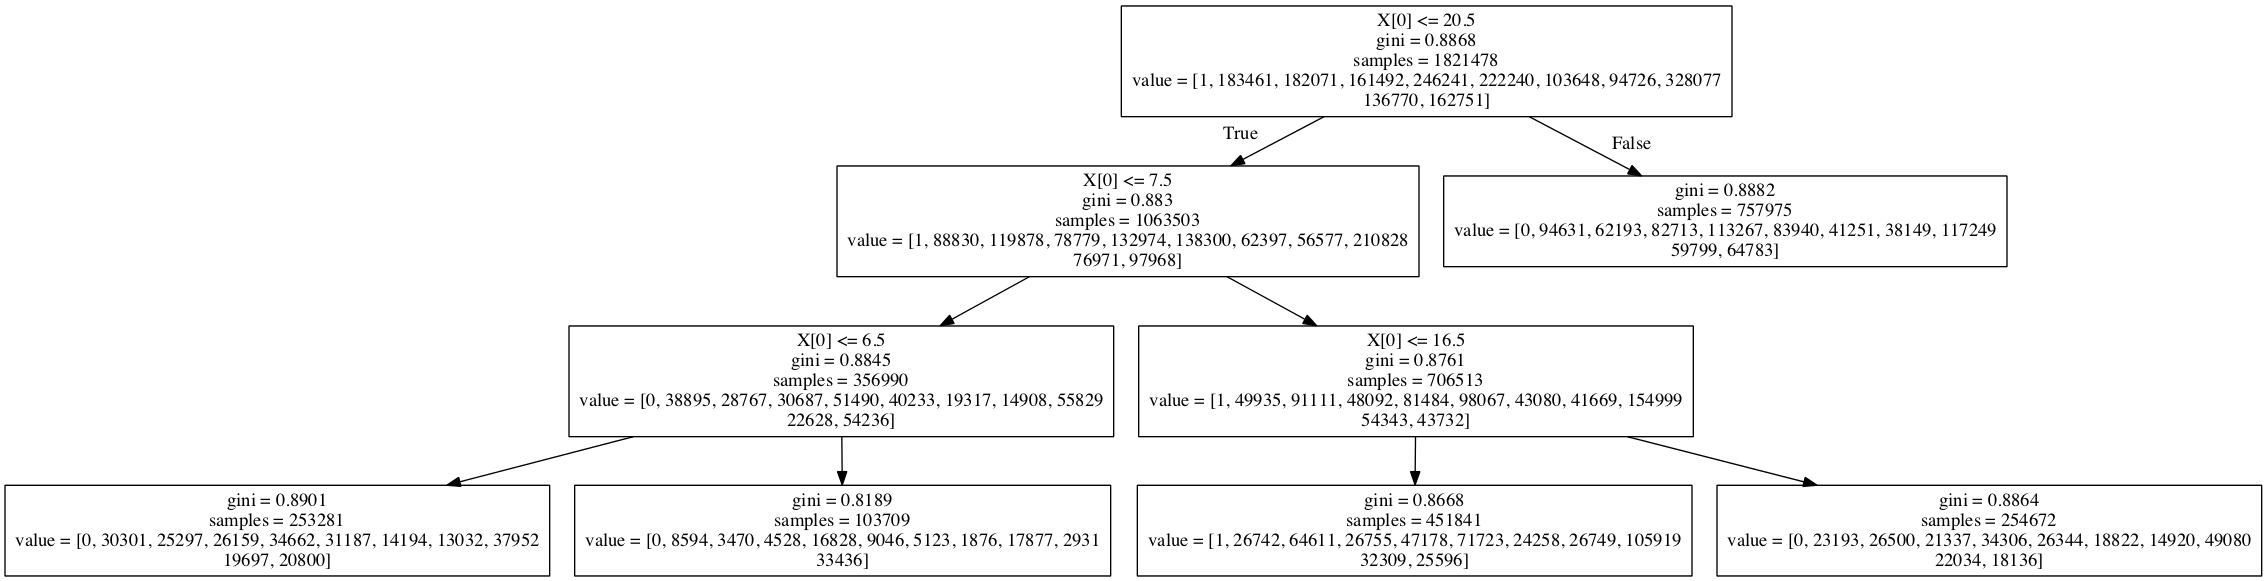

In [25]:
def show_tree(decisionTree):
    dot_data = StringIO()  
    tree.export_graphviz(decisionTree, out_file=dot_data)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
    return Image(graph.create_png()) 
    
show_tree(clf)

>* *As you might see in the visualization, the tree runs out of possible feature values to check before refining the decision. Try increasing the number of features: add part of the day (night=0-5, morning=6-10, midday=11-14, afternoon=15-17, evening=18-23). Is it better? What is the problem we're solving by breaking the day into parts rather than raw hour values?*

In [26]:
# Extract hour from time
def getHour(time):
    return int(time.split(':')[0])

# Assign label to a range of hours
def getPeriod(hour):
    if hour >= 0 and hour <= 5:
        return 'night'
    if hour >= 6 and hour <= 10:
        return 'morning'
    if hour >= 11 and hour <= 14:
        return 'midday'
    if hour >= 15 and hour <= 17:
        return 'afternoon'
    if hour >= 18 and hour <= 23:
        return 'evening'

# Add 'Hour' column
df['Hour']= df['Time'].apply(lambda x: getHour(x))
# Add 'Period' column
df['Period'] = df['Hour'].apply(lambda x: getPeriod(x))

In [27]:
# Keep only data used for decision tree
df_tree_day_hour = df.filter(items = ['Category', 'DayOfWeek', 'Period', 'PdDistrict'])
df_tree_day_hour.head()

,Category,DayOfWeek,Period,PdDistrict
0,NON-CRIMINAL,Monday,midday,MISSION
1,ROBBERY,Sunday,afternoon,TENDERLOIN
2,ASSAULT,Sunday,afternoon,TENDERLOIN
3,SECONDARY CODES,Sunday,afternoon,TENDERLOIN
4,VANDALISM,Tuesday,evening,NORTHERN


In [28]:
#Encode categorical variables to digits
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
X_1 = le1.fit_transform(df_tree_day_hour['Category'])
X_2 = le2.fit_transform(df_tree_day_hour['DayOfWeek'])  
X_3 = le3.fit_transform(df_tree_day_hour['Period'])
Y = le4.fit_transform(df_tree_day_hour['PdDistrict'])

In [29]:
# Split training and testing data 
X_train, X_test, Y_train, Y_test = train_test_split(np.column_stack((X_1,X_2,X_3)), Y, test_size=0.1, random_state=0)

In [30]:
#Train the decision tree classifier
clf = tree.DecisionTreeClassifier(criterion='gini', min_samples_split=2)
#The scikit-learn fit function needs a list of lists as input even if the nested lists have length 1
clf = clf.fit(X_train, Y_train[:,None])
print 'Fraction of correct predictions : %.2f%%' % (clf.score(X_test,Y_test[:,None])*100)

Fraction of correct predictions : 20.37%


We split the hours into buckets in order to minimize the range of the column and eventually, improve the performance of the classifier. After fitting the classifier with the new feature, there was a small improvement(+0.13%) but nothing that important to rely on.


>* *Let's try some examples to see if the algorithm is working.*

Before running the examples we should map the encoded values in order to be sure that we try to predict the right crimes.

In [31]:
def mapper(column,encoder,data):
    dict_temp = {}
    # Initiate PrettyTable
    table = PrettyTable(field_names=[column,'Mapping_Index'])

    for i,item in enumerate(encoder.inverse_transform(data)):
        dict_temp[item]=data[i]

    # Sort dictionary by value
    sorted_dict = sorted(dict_temp.items(), key=operator.itemgetter(1))

    # Fit the Pretty Table
    for i in sorted_dict:
        table.add_row([i[0],i[1]])
    return '--------%s Mapper--------\n%s\n' % (column,table),sorted_dict

In [32]:
# Print all mapping tables
print mapper('Category',le1,X_1)[0]
print mapper('DayOfWeek',le2,X_2)[0]
print mapper('Period',le3,X_3)[0]
print mapper('PdDistrict',le4,Y)[0]

--------Category Mapper--------
+-----------------------------+---------------+
|           Category          | Mapping_Index |
+-----------------------------+---------------+
|            ARSON            |       0       |
|           ASSAULT           |       1       |
|          BAD CHECKS         |       2       |
|           BRIBERY           |       3       |
|           BURGLARY          |       4       |
|      DISORDERLY CONDUCT     |       5       |
| DRIVING UNDER THE INFLUENCE |       6       |
|        DRUG/NARCOTIC        |       7       |
|         DRUNKENNESS         |       8       |
|         EMBEZZLEMENT        |       9       |
|          EXTORTION          |       10      |
|       FAMILY OFFENSES       |       11      |
|    FORGERY/COUNTERFEITING   |       12      |
|            FRAUD            |       13      |
|           GAMBLING          |       14      |
|          KIDNAPPING         |       15      |
|        LARCENY/THEFT        |       16      |
|       

Now that we know exactly what values to add on the **predict** module, we can proceed with the following.

>* *There is a new crime (prositution) on Monday 10pm. What are the three most likely districts?*

In [33]:
def district_predictor(category_index,day_index,period_index):
    '''Predict the top 3 districts function'''
    
    # Find the probability of each each district and convert it to list
    probs = clf.predict_proba([category_index,day_index,period_index]).tolist()[0]
    
    # Keep an index of the predicted array
    index = [i for i,item in enumerate(probs)]
    
    # Put the top 3 in tuples
    top = sorted(zip(probs, index), reverse=True)[:3]
    
    # Initiate PrettyTable
    table = PrettyTable(field_names=['District','Probability'])
    
    for i,item in enumerate(top):
        table.add_row([mapper('PdDistrict',le4,Y)[1][item[1]][0],str(round(item[0]*100,2))+'%'])
    print ' Top 3 Predicted Districts\n',table

In [34]:
district_predictor(23,1,1)

 Top 3 Predicted Districts
+------------+-------------+
|  District  | Probability |
+------------+-------------+
|  MISSION   |    66.18%   |
|  NORTHERN  |    11.66%   |
| TENDERLOIN |    7.58%    |
+------------+-------------+


The above means that it is more likely that a Prostitution crime commited on Monday 10pm, to be commited in **MISSION** district. 

>* *Also find the most likely districts for a gambling on Wednesday 1pm.*

In [35]:
district_predictor(14,6,2)

 Top 3 Predicted Districts
+-----------+-------------+
|  District | Probability |
+-----------+-------------+
| INGLESIDE |    22.73%   |
|  NORTHERN |    18.18%   |
|  BAYVIEW  |    18.18%   |
+-----------+-------------+


>* *And also try out an arson case on Sunday 7am?*

In [36]:
district_predictor(0,3,3)

 Top 3 Predicted Districts
+-----------+-------------+
|  District | Probability |
+-----------+-------------+
|  BAYVIEW  |    30.43%   |
| INGLESIDE |    17.39%   |
|  SOUTHERN |    13.04%   |
+-----------+-------------+


>* *It's unlikely that the classifier overfits in our case. Explain why.*

In order to experience overfitting, we should have brought too rich complexity in our model relative to the size of the training sample of which we developed the model. For that reason, it is unlikely that our classifier overfits.

## Part 2: Clustering (DSFS Chapter 19)

>Exercise: K-means
>* *Visualize the prostitution data (e.g. by plotting it on a map)*

In [37]:
# Filter out Prostitution only
df_kmeans = df[df['Category']=='PROSTITUTION']
df_kmeans = df_kmeans.filter(items=['Category','X','Y'])
df_kmeans.head()

,Category,X,Y
3395,PROSTITUTION,-122.485039,37.761291
3639,PROSTITUTION,-122.466205,37.772541
5423,PROSTITUTION,-122.403405,37.775421
6863,PROSTITUTION,-122.409661,37.786439
7561,PROSTITUTION,-122.417956,37.757880


In [38]:
def kde_plot(df_geo_data_plot,geo_data_bounding):
    '''Plot the KDE on a map'''
    
    # Create a dictionary and put crime's coordinates as a separate key,value pair and plot the KDE
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_geo_data_plot['Y'])],
                             "lon": [float(el) for el in list(df_geo_data_plot['X'])]}
    
    geoplotlib.kde(geo_data_for_plotting,bw=2,binsize=0.5,cmap='jet')
    bbox = BoundingBox(north=max(geo_data_bounding['lat']),
                       west=min(geo_data_bounding['lon']),
                       south=min(geo_data_bounding['lat']),
                       east=max(geo_data_bounding['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()

###############################################################################################################   
def dot_plot(df_geo_data_plot,geo_data_bounding,n_clusters):
    '''Plot the dotplot on a map'''
    colors = ['red', 'green', 'blue','black','green', 'green', 'blue','black','black','green']
    
    # Create a dictionary and put each crime's coordinates as a separate key,value pair and plot the KDE
    geo_dict = {}
    for cluster in range(n_clusters):
        geo_data_for_plotting = {"lat": [float(el) for el in list(df_kmeans[df_kmeans[str(n_clusters)+'_clusters']==cluster]['Y'])], 
                                 "lon": [float(el) for el in list(df_kmeans[df_kmeans[str(n_clusters)+'_clusters']==cluster]['X'])]}
        geo_dict[cluster] = geo_data_for_plotting

    for i,cluster in enumerate(list(df_geo_data_plot[str(n_clusters)+'_clusters'].unique())):
        geoplotlib.dot(geo_dict[cluster], color=colors[i], point_size=2)

    bbox = BoundingBox(north=max(geo_data_bounding['lat']),
                       west=min(geo_data_bounding['lon']),
                       south=min(geo_data_bounding['lat']),
                       east=max(geo_data_bounding['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()
    
###############################################################################################################     
# Remove the outliers
df_kmeans = df_kmeans[df_kmeans['Y']!=90]
df = df[df['Y']!=90]

# Create a dictionary and put all crime's coordinates for a standardized bounding box
geo_data_for_bounding_box = {"lat": [float(el) for el in list(df['Y'])],
                             "lon": [float(el) for el in list(df['X'])]}

In [39]:
# Plot the KDE on the map for PROSTITUTION data
kde_plot(df_kmeans,geo_data_for_bounding_box)

('smallest non-zero count', 8.955579620337621e-09)
('max count:', 47.087716466616847)


>* *Train models of K=2,…,10 on the prostitution data.*

In [60]:
# Assign X and Y coordinates to K-means classifier
X = np.array(df_kmeans[['X','Y']])

# Initialize the KMeans algorithm and fit
def k_means_fit(n_clusters,features):
    clf = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    return clf

In [61]:
# Create a cluster reference for each K
for i in range(2,11):
    df_kmeans[str(i)+'_clusters'] = pd.Series(k_means_fit(i,X).labels_, index=df_kmeans.index)
df_kmeans.head()    

,Category,X,Y,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,9_clusters,10_clusters
3395,PROSTITUTION,-122.485039,37.761291,1,2,3,3,4,3,3,4,3
3639,PROSTITUTION,-122.466205,37.772541,1,2,3,3,4,3,3,4,3
5423,PROSTITUTION,-122.403405,37.775421,0,1,0,4,0,4,4,3,4
6863,PROSTITUTION,-122.409661,37.786439,0,1,0,4,0,4,4,3,4
7561,PROSTITUTION,-122.417956,37.757880,1,0,1,0,1,1,6,0,7


In [43]:
# Plot the 3 maps for K = 2,3 and 4
for i in range(2,5):
    dot_plot(df_kmeans,geo_data_for_bounding_box,i)

We can see on the above maps how the K-means classifier groups the coordinates in 2,3 and 4 clusters adequately.

>* *Explore how the total squared error changes as a function of K and identify what you think is the right number of clusers based on the knee-point in the squared error plot.*

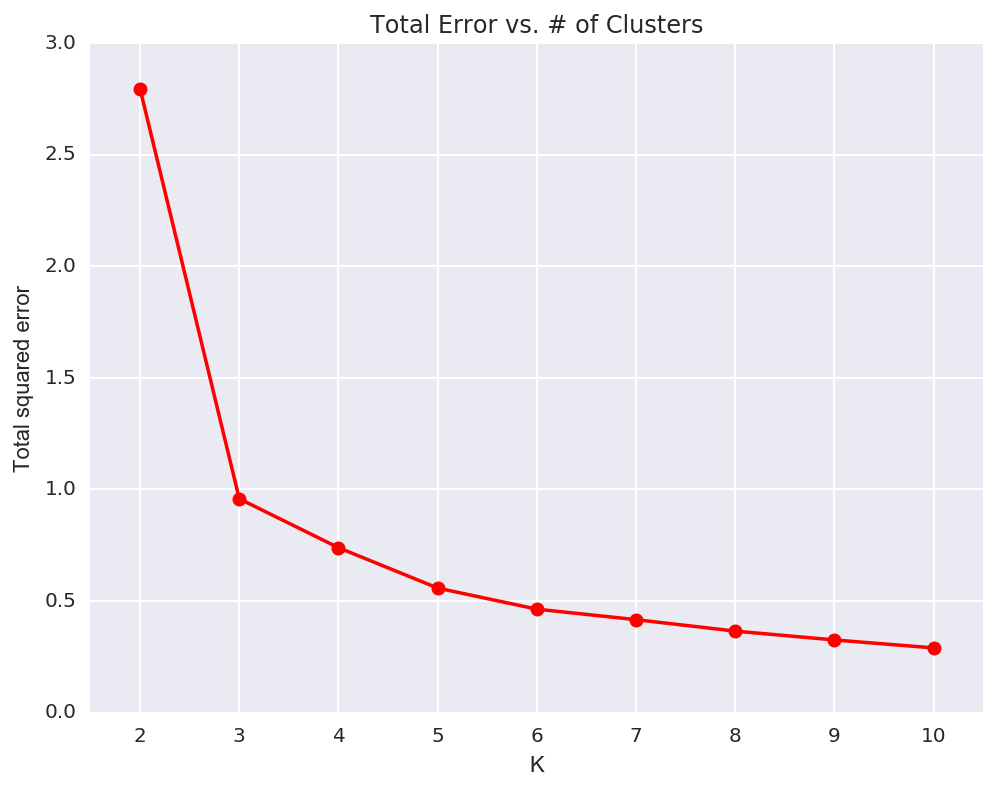

In [62]:
%config InlineBackend.figure_format = 'retina'
def squared_errors(n_clusters,features):
    clf = k_means_fit(n_clusters,features)
    return clf.inertia_

n_k = range(2,11)
errors = [squared_errors(k,X) for k in n_k]
plt.figure(figsize=(8,6))
plt.plot(n_clusters, errors,'r-o')
plt.xticks(n_clusters)
plt.xlabel("K")
plt.xlim(1.5,10.5)
plt.ylabel("Total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()